In [1]:
import numpy as np
import os
os.environ["SCIPY_USE_PROPACK"] = "True"
import scipy
from scipy.sparse.linalg import svds as truncated_svd
from scipy.linalg import svd as plain_svd
from scipy.sparse.linalg import cg
import quimb as qu
import matplotlib.pyplot as plt
import sys
from tqdm.notebook import tqdm

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# Initial conditions for TDJ
def J(X, Y, u_0, y_min=0.4, y_max=0.6, h = 0.005):
    return u_0/2*(np.tanh((Y-y_min)/h)-np.tanh((Y-y_max)/h)-1), np.zeros_like(Y)

def d_1(X, Y, y_min=0.4, y_max=0.6, h=0.005, L_box=1):
    return 2*L_box/h**2*((Y-y_max)*np.exp(-(Y-y_max)**2/h**2)+(Y-y_min)*np.exp(-(Y-y_min)**2/h**2))*(np.sin(8*np.pi*X/L_box)+np.sin(24*np.pi*X/L_box)+np.sin(6*np.pi*X/L_box))

def d_2(X, Y, y_min=0.4, y_max=0.6, h=0.005, L_box=1):
    return np.pi*(np.exp(-(Y-y_max)**2/h**2)+np.exp(-(Y-y_min)**2/h**2))*(8*np.cos(8*np.pi*X/L_box)+24*np.cos(24*np.pi*X/L_box)+6*np.cos(6*np.pi*X/L_box))

def D(X, Y, u_0, y_min, y_max, h, L_box):
    d1 = d_1(X, Y, y_min, y_max, h, L_box)
    d2 = d_2(X, Y, y_min, y_max, h, L_box)
    delta = u_0/(40*np.max(np.sqrt(d1**2+d2**2)))
    return delta*d1, delta*d2

In [3]:
def CreateFields2D(L, N, y_min, y_max, h, u_max):
    dx = L/N    # dx=dy

    # create 2D grid
    x = np.linspace(0, L-dx, N)
    y = np.linspace(0, L-dx, N)
    Y, X = np.meshgrid(y, x)

    # load initial conditions for TDJ
    U, V = J(X, Y, u_max, y_min, y_max, h)
    dU, dV = D(X, Y, u_max, y_min, y_max, h, L)
    U = U + dU
    V = V + dV

    return U, V

In [4]:
def get_F_index(binary):
    # get index in original array
    # binary = sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    # F_index = sig_1^x sig_2^x ... sig_n_bits^x sig_1^y sig_2^y ... sig_n_bits^y
    return int(binary[::2]+binary[1::2], 2)

In [5]:
def svd(mat, chi=None):
    min_dim = np.min(mat.shape)
    if chi == None or chi >= min_dim:   # plain svd
        U, S, V = plain_svd(mat, full_matrices=False)
        S = np.diag(S)
    else:   # truncated svd
        chi_k = min_dim-1
        if chi < chi_k:
            chi_k = chi
        U, S, V = truncated_svd(mat, chi_k)
        S = np.diag(S)

    return U, S, V

In [6]:
def convert_to_MPS2D(F, chi=None):  # converts scalar field to scale-resolved MPS matrices
    Nx, Ny = F.shape            # Get number of points (Nx equals Ny)
    n = int(np.log2(Nx))        # Get number of (qu)bits
    F_vec = F.reshape((1, -1))  # Flatten function
    
    # Reshape into scale resolving representation C
    w = '0'*2*n                                 # index sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    C_vec = np.zeros(4**n).reshape((1, -1))     # similar to F but with scale indices

    for _ in range(4**n):
        F_index = get_F_index(w)                # get original index for w
        C_index = int(w, 2)                     # get corresponding index for w
        w = bin(C_index+1)[2:].zfill(2*n)       # set w += 1 in binary
        C_vec[0, C_index] = F_vec[0, F_index]   

    node = C_vec    # set first node of MPS
    MPS = []        # create MPS as list of matrices
    S_mats = []     # create list for singular value matrices 

    for i in range(n-1):
        # node = expand_rows(node, 4)     # move first index from columns to rows
        m, n = node.shape
        node = node.reshape((4*m, int(n/4)))
        U, S, V = svd(node, chi)        # svd
        MPS.append(U)                   # save U as first node of MPS
        S_mats.append(S)                # save S
        node = np.matmul(S, V)          # create remaining matrix S*V for next expansion step

    m, n = node.shape
    node = node.reshape((4*m, int(n/4)))
    MPS.append(node)    # add last node to MPS

    return MPS

In [7]:
def convert_to_VF2D(MPS):   # converts scale-resolved MPS matrices to scalar field
    n_bits = len(MPS)
    N = 2**n_bits
    node_L = MPS[0]
    for i in range(1, n_bits):
        m, n = node_L.shape
        node_R = MPS[i].reshape((n, -1))
        node_L = np.matmul(node_L, node_R)
        m, n = node_L.shape
        node_L = node_L.reshape((4*m, int(n/4)))
    C_vec = node_L.reshape((1, -1)) 

    w = '0'*2*n_bits                            # index sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    F_vec = np.zeros(4**n_bits).reshape((1, -1))     # similar to C but with dimensional indices

    for _ in range(4**n_bits):
        F_index = get_F_index(w)             
        C_index = int(w, 2)                   
        w = bin(C_index+1)[2:].zfill(2*n_bits)     
        F_vec[0, F_index]  = C_vec[0, C_index]

    return F_vec.reshape((N, N))

In [8]:
def convert_MPS_to_quimb(tensor_list, dim_ls):  # converts scale-resolved MPS matrices to quimb MPS
    arrays = []
    for i, tensor in enumerate(tensor_list):
        m, n = tensor.shape             # m = dim_left_bond*dim_ls, n = dim_right_bond
        dim_left_bond = int(m/dim_ls)   # dimension of left bond
        dim_right_bond = n              # dimension of right bond
        if dim_left_bond == 1:          # the first tensor as no left bond
            data = tensor.reshape((dim_ls, dim_right_bond)).transpose()
        elif dim_right_bond == 1:       # the last tensor has no right bond
            data = tensor.reshape((dim_left_bond, dim_ls)).transpose()
        else:
            data = tensor.reshape((dim_left_bond, dim_ls, dim_right_bond))
        arrays.append(data)
    
    return qu.tensor.MatrixProductState(arrays, shape='lpr')


In [9]:
def convert_MPS_to_quimb_old(tensor_list, dim_ls):
    arrays = []
    for i, tensor in enumerate(tensor_list):
        m, n = tensor.shape
        dim_left_bond = int(m/dim_ls)
        dim_right_bond = n
        data = tensor.reshape((dim_left_bond, dim_ls, dim_right_bond))
        arrays.append(data)
    
    return qu.tensor.MatrixProductState(arrays, shape='lpr')


In [9]:
def convert_quimb_to_MPS(quimb_MPS):    # converts quimb MPS to scale-resolved MPS matrices
    MPS = []
    for i, array in enumerate(quimb_MPS.arrays):
        if i == 0:                      # the first tensor as no left bond
            r, p = array.shape
            MPS.append(array.transpose().reshape((p, r)))
        elif i == quimb_MPS.L-1:        # the last tensor as no right bond
            l, p = array.shape
            MPS.append(array.reshape((l*p, 1)))
        else:
            l, r, p = array.shape
            MPS.append(np.transpose(array, (0, 2, 1)).reshape((l*p, r)))
    
    return MPS

In [11]:
def convert_quimb_to_MPS_old(quimb_MPS):
    MPS = []
    for i, array in enumerate(quimb_MPS.arrays):
        l, r, p = array.shape
        MPS.append(np.transpose(array, (0, 2, 1)).reshape((l*p, r)))
    
    return MPS

In [10]:
# Build 2D TDJ in quimb MPS form
def buildFluidField2DMPS():
    # Create field
    n_bits = 10
    N = 2**n_bits
    L = 1
    chi = N

    # Initial conditions
    y_min = 0.4
    y_max = 0.6
    h = 1/200 
    u_max = 1
    epsilon = 10^-8

    # Set timesteps
    dt = 0.1*2**-(n_bits-1)
    T = 2

    # Set penalty factor for breach of incompressibility condition
    dx = 2**-n_bits-1
    lam = dx**2 * 10**4

    # Generate initial fields
    U, V = CreateFields2D(L, N, y_min, y_max, h, u_max) 

    # Rescale into non-dimensional units
    U = U/u_max
    V = V/u_max

    # Convert them to MPS form
    MPS_U = convert_to_MPS2D(U, chi)
    MPS_V = convert_to_MPS2D(V, chi)

    # Tranform into quimb MPS form
    MPS_U_quimb = convert_MPS_to_quimb(MPS_U, 4)
    MPS_V_quimb = convert_MPS_to_quimb(MPS_V, 4)

    return MPS_U_quimb, MPS_V_quimb, MPS_U, MPS_V

In [11]:
def Diff_1_2_y_MPO(n, dx):
    # first order derivative with second order precision in y direction
    # tensor stucture:
    #                          |
    # left_terminator - (central_node)^n - right_terminator
    #                          |
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    central_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    central_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    central_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    central_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    central_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    central_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry(0)
    right_terminator = 1/dx*np.array([0, 1/2, -1/2]).reshape(3, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(central_node.reshape(-1, 3), right_terminator).reshape(4, 3, 4)
    arrays = [left_node] + [central_node]*(n-2) + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [12]:
def Diff_1_2_x_MPO(n, dx):
    # first order derivative with second order precision in x direction
    # tensor stucture:
    #                          |
    # left_terminator - (central_node)^n - right_terminator
    #                          |
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    central_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    central_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    central_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    central_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    central_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    central_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    right_terminator = 1/dx*np.array([0, 1/2, -1/2]).reshape(3, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(central_node.reshape(-1, 3), right_terminator).reshape(4, 3, 4)
    arrays = [left_node] + [central_node]*(n-2) + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [13]:
def Diff_2_2_y_MPO(n, dx):
    # second order derivative with second order precision in y direction
    # tensor stucture:
    #                          |
    # left_terminator - (central_node)^n - right_terminator
    #                          
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    central_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    central_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    central_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    central_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    central_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    central_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry(0)
    right_terminator = 1/dx**2*np.array([-2, 1, 1]).reshape(3, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(central_node.reshape(-1, 3), right_terminator).reshape(4, 3, 4)
    arrays = [left_node] + [central_node]*(n-2) + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [14]:
def Diff_2_2_x_MPO(n, dx):
    # second order derivative with second order precision in x direction
    # tensor stucture:
    #                          |
    # left_terminator - (central_node)^n - right_terminator
    #                          |
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    central_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    central_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    central_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    central_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    central_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    central_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    right_terminator = 1/dx**2*np.array([-2, 1, 1]).reshape(3, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(central_node.reshape(-1, 3), right_terminator).reshape(4, 3, 4)
    arrays = [left_node] + [central_node]*(n-2) + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [15]:
def Diff_1_8_y_MPO(n, dx):
    # first order derivative with eigth order precision in y direction
    # tensor stucture:
    #                          |                         |               |
    # left_terminator - (central_node)^(n-2) - second to last node - last node - right_terminator
    #                          |                         |               |
    # left terminator
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    # central node
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    central_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    central_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    central_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    central_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    central_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    central_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry(0)
    # second to last node
    sec_last_node = np.zeros((4, 3, 4, 5))  # down, left, up, right
    # 0 from right: identity
    sec_last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    sec_last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    sec_last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    sec_last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    sec_last_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    sec_last_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    sec_last_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    sec_last_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    sec_last_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    sec_last_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    sec_last_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    sec_last_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry (0)
    # 3 from right: identity with carry for addition
    sec_last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    sec_last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    sec_last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    sec_last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    # 4 from right: identity with carry for substraction
    sec_last_node[0, 2, 0, 4] =  1   # 00 -> 00 carry for substraction (2)
    sec_last_node[1, 2, 1, 4] =  1   # 01 -> 01 carry for substraction (2)
    sec_last_node[2, 2, 2, 4] =  1   # 10 -> 10 carry for substraction (2)
    sec_last_node[3, 2, 3, 4] =  1   # 11 -> 11 carry for substraction (2)
    # last node
    last_node = np.zeros((4, 5, 4, 6))  # down, left, up, right
    # 0 from right: identity
    last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    last_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    last_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    last_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    last_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    last_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    last_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    last_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    last_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry (0)
    # 3 from right: add and substract 2
    last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    last_node[0, 2, 0, 3] = -1   # 00 -> 00 carry for substraction (2)
    last_node[1, 2, 1, 3] = -1   # 01 -> 01 carry for substraction (2)
    last_node[2, 2, 2, 3] = -1   # 10 -> 10 carry for substraction (2)
    last_node[3, 2, 3, 3] = -1   # 11 -> 11 carry for substraction (2)
    # 4 from right: add and substract 3
    last_node[0, 1, 1, 4] = 1    # 00 -> 01 carry for addition (1)
    last_node[1, 3, 0, 4] = 1    # 01 -> 00 carry for addition one further (3)
    last_node[2, 1, 3, 4] = 1    # 10 -> 11 carry for addition (1)
    last_node[3, 3, 2, 4] = 1    # 11 -> 10 carry for addition one further (3)
    last_node[0, 4, 1, 4] = -1   # 00 -> 01 carry for substraction one further (4)
    last_node[1, 2, 0, 4] = -1   # 01 -> 00 carry for substraction (2)
    last_node[2, 4, 3, 4] = -1   # 10 -> 11 carry for substraction one further (4)
    last_node[3, 2, 2, 4] = -1   # 11 -> 10 carry for substraction (2)
    # 5 from right: add and substract 4
    last_node[0, 3, 0, 5] = 1    # 00 -> 00 carry for addition one further (3)
    last_node[1, 3, 1, 5] = 1    # 01 -> 01 carry for addition one further (3)
    last_node[2, 3, 2, 5] = 1    # 10 -> 10 carry for addition one further (3)
    last_node[3, 3, 3, 5] = 1    # 11 -> 11 carry for addition one further (3)
    last_node[0, 4, 0, 5] = -1   # 00 -> 00 carry for substraction one further (4)
    last_node[1, 4, 1, 5] = -1   # 01 -> 01 carry for substraction one further (4)
    last_node[2, 4, 2, 5] = -1   # 10 -> 10 carry for substraction one further (4)
    last_node[3, 4, 3, 5] = -1   # 11 -> 11 carry for substraction one further (4)
    # right terminator
    right_terminator = 1/dx*np.array([0, 4/5, -4/5, -1/5, 4/105, -1/280]).reshape(6, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(last_node.reshape(-1, 6), right_terminator).reshape(4, 5, 4)
    arrays = [left_node] + [central_node]*(n-3) + [sec_last_node] + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [16]:
def Diff_1_8_x_MPO(n, dx):
    # first order derivative with eighth order precision in x direction
    # tensor stucture:
    #                          |                         |               |
    # left_terminator - (central_node)^(n-2) - second to last node - last node - right_terminator
    #                          |                         |               |
    # left terminator
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    # central node
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    central_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    central_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    central_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    central_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    central_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    central_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # second to last node
    sec_last_node = np.zeros((4, 3, 4, 5))  # down, left, up, right
    # 0 from right: identity
    sec_last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    sec_last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    sec_last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    sec_last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    sec_last_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    sec_last_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    sec_last_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    sec_last_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    sec_last_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    sec_last_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    sec_last_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    sec_last_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # 3 from right: identity with carry for addition
    sec_last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    sec_last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    sec_last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    sec_last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    # 4 from right: identity with carry for substraction
    sec_last_node[0, 2, 0, 4] =  1   # 00 -> 00 carry for substraction (2)
    sec_last_node[1, 2, 1, 4] =  1   # 01 -> 01 carry for substraction (2)
    sec_last_node[2, 2, 2, 4] =  1   # 10 -> 10 carry for substraction (2)
    sec_last_node[3, 2, 3, 4] =  1   # 11 -> 11 carry for substraction (2)
    # last node
    last_node = np.zeros((4, 5, 4, 6))  # down, left, up, right
    # 0 from right: identity
    last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    last_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    last_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    last_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    last_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    last_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    last_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    last_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    last_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # 3 from right: add and substract 2
    last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    last_node[0, 2, 0, 3] = -1   # 00 -> 00 carry for substraction (2)
    last_node[1, 2, 1, 3] = -1   # 01 -> 01 carry for substraction (2)
    last_node[2, 2, 2, 3] = -1   # 10 -> 10 carry for substraction (2)
    last_node[3, 2, 3, 3] = -1   # 11 -> 11 carry for substraction (2)
    # 4 from right: add and substract 3
    last_node[0, 1, 2, 4] = 1    # 00 -> 10 carry for addition (1)
    last_node[1, 1, 3, 4] = 1    # 01 -> 11 carry for addition (1)
    last_node[2, 3, 0, 4] = 1    # 10 -> 00 carry for addition one further (3)
    last_node[3, 3, 1, 4] = 1    # 11 -> 01 carry for addition one further (3)
    last_node[0, 4, 2, 4] = -1   # 00 -> 10 carry for substraction one further (4)
    last_node[1, 4, 3, 4] = -1   # 01 -> 11 carry for substraction one further (4)
    last_node[2, 2, 0, 4] = -1   # 10 -> 00 carry for substraction (2)
    last_node[3, 2, 1, 4] = -1   # 11 -> 01 carry for substraction (2)
    # 5 from right: add and substract 4
    last_node[0, 3, 0, 5] = 1    # 00 -> 00 carry for addition one further (3)
    last_node[1, 3, 1, 5] = 1    # 01 -> 01 carry for addition one further (3)
    last_node[2, 3, 2, 5] = 1    # 10 -> 10 carry for addition one further (3)
    last_node[3, 3, 3, 5] = 1    # 11 -> 11 carry for addition one further (3)
    last_node[0, 4, 0, 5] = -1   # 00 -> 00 carry for substraction one further (4)
    last_node[1, 4, 1, 5] = -1   # 01 -> 01 carry for substraction one further (4)
    last_node[2, 4, 2, 5] = -1   # 10 -> 10 carry for substraction one further (4)
    last_node[3, 4, 3, 5] = -1   # 11 -> 11 carry for substraction one further (4)
    # right terminator
    right_terminator = 1/dx*np.array([0, 4/5, -4/5, -1/5, 4/105, -1/280]).reshape(6, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(last_node.reshape(-1, 6), right_terminator).reshape(4, 5, 4)
    arrays = [left_node] + [central_node]*(n-3) + [sec_last_node] + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [17]:
def Diff_2_8_y_MPO(n, dx):
    # second order derivative with eigth order precision in y direction
    # tensor stucture:
    #                          |                         |               |
    # left_terminator - (central_node)^(n-2) - second to last node - last node - right_terminator
    #                          |                         |               |
    # left terminator
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    # central node
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    central_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    central_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    central_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    central_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    central_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    central_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry(0)
    # second to last node
    sec_last_node = np.zeros((4, 3, 4, 5))  # down, left, up, right
    # 0 from right: identity
    sec_last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    sec_last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    sec_last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    sec_last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    sec_last_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    sec_last_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    sec_last_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    sec_last_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    sec_last_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    sec_last_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    sec_last_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    sec_last_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry (0)
    # 3 from right: identity with carry for addition
    sec_last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    sec_last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    sec_last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    sec_last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    # 4 from right: identity with carry for substraction
    sec_last_node[0, 2, 0, 4] =  1   # 00 -> 00 carry for substraction (2)
    sec_last_node[1, 2, 1, 4] =  1   # 01 -> 01 carry for substraction (2)
    sec_last_node[2, 2, 2, 4] =  1   # 10 -> 10 carry for substraction (2)
    sec_last_node[3, 2, 3, 4] =  1   # 11 -> 11 carry for substraction (2)
    # last node
    last_node = np.zeros((4, 5, 4, 6))  # down, left, up, right
    # 0 from right: identity
    last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    last_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    last_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    last_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    last_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    last_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    last_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    last_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    last_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry (0)
    # 3 from right: add and substract 2
    last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    last_node[0, 2, 0, 3] = 1    # 00 -> 00 carry for substraction (2)
    last_node[1, 2, 1, 3] = 1    # 01 -> 01 carry for substraction (2)
    last_node[2, 2, 2, 3] = 1    # 10 -> 10 carry for substraction (2)
    last_node[3, 2, 3, 3] = 1    # 11 -> 11 carry for substraction (2)
    # 4 from right: add and substract 3
    last_node[0, 1, 1, 4] = 1    # 00 -> 01 carry for addition (1)
    last_node[1, 3, 0, 4] = 1    # 01 -> 00 carry for addition one further (3)
    last_node[2, 1, 3, 4] = 1    # 10 -> 11 carry for addition (1)
    last_node[3, 3, 2, 4] = 1    # 11 -> 10 carry for addition one further (3)
    last_node[0, 4, 1, 4] = 1    # 00 -> 01 carry for substraction one further (4)
    last_node[1, 2, 0, 4] = 1    # 01 -> 00 carry for substraction (2)
    last_node[2, 4, 3, 4] = 1    # 10 -> 11 carry for substraction one further (4)
    last_node[3, 2, 2, 4] = 1    # 11 -> 10 carry for substraction (2)
    # 5 from right: add and substract 4
    last_node[0, 3, 0, 5] = 1    # 00 -> 00 carry for addition one further (3)
    last_node[1, 3, 1, 5] = 1    # 01 -> 01 carry for addition one further (3)
    last_node[2, 3, 2, 5] = 1    # 10 -> 10 carry for addition one further (3)
    last_node[3, 3, 3, 5] = 1    # 11 -> 11 carry for addition one further (3)
    last_node[0, 4, 0, 5] = 1    # 00 -> 00 carry for substraction one further (4)
    last_node[1, 4, 1, 5] = 1    # 01 -> 01 carry for substraction one further (4)
    last_node[2, 4, 2, 5] = 1    # 10 -> 10 carry for substraction one further (4)
    last_node[3, 4, 3, 5] = 1    # 11 -> 11 carry for substraction one further (4)
    # right terminator
    right_terminator = 1/dx**2*np.array([-205/72, 8/5, 8/5, -1/5, 8/315, -1/560]).reshape(6, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(last_node.reshape(-1, 6), right_terminator).reshape(4, 5, 4)
    arrays = [left_node] + [central_node]*(n-3) + [sec_last_node] + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [18]:
def Diff_2_8_x_MPO(n, dx):
    # second order derivative with eighth order precision in x direction
    # tensor stucture:
    #                          |                         |               |
    # left_terminator - (central_node)^(n-2) - second to last node - last node - right_terminator
    #                          |                         |               |
    # left terminator
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    # central node
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    central_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    central_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    central_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    central_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    central_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    central_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # second to last node
    sec_last_node = np.zeros((4, 3, 4, 5))  # down, left, up, right
    # 0 from right: identity
    sec_last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    sec_last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    sec_last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    sec_last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    sec_last_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    sec_last_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    sec_last_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    sec_last_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    sec_last_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    sec_last_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    sec_last_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    sec_last_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # 3 from right: identity with carry for addition
    sec_last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    sec_last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    sec_last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    sec_last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    # 4 from right: identity with carry for substraction
    sec_last_node[0, 2, 0, 4] =  1   # 00 -> 00 carry for substraction (2)
    sec_last_node[1, 2, 1, 4] =  1   # 01 -> 01 carry for substraction (2)
    sec_last_node[2, 2, 2, 4] =  1   # 10 -> 10 carry for substraction (2)
    sec_last_node[3, 2, 3, 4] =  1   # 11 -> 11 carry for substraction (2)
    # last node
    last_node = np.zeros((4, 5, 4, 6))  # down, left, up, right
    # 0 from right: identity
    last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    last_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    last_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    last_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    last_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    last_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    last_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    last_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    last_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # 3 from right: add and substract 2
    last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    last_node[0, 2, 0, 3] = 1    # 00 -> 00 carry for substraction (2)
    last_node[1, 2, 1, 3] = 1    # 01 -> 01 carry for substraction (2)
    last_node[2, 2, 2, 3] = 1    # 10 -> 10 carry for substraction (2)
    last_node[3, 2, 3, 3] = 1    # 11 -> 11 carry for substraction (2)
    # 4 from right: add and substract 3
    last_node[0, 1, 2, 4] = 1    # 00 -> 10 carry for addition (1)
    last_node[1, 1, 3, 4] = 1    # 01 -> 11 carry for addition (1)
    last_node[2, 3, 0, 4] = 1    # 10 -> 00 carry for addition one further (3)
    last_node[3, 3, 1, 4] = 1    # 11 -> 01 carry for addition one further (3)
    last_node[0, 4, 2, 4] = 1    # 00 -> 10 carry for substraction one further (4)
    last_node[1, 4, 3, 4] = 1    # 01 -> 11 carry for substraction one further (4)
    last_node[2, 2, 0, 4] = 1    # 10 -> 00 carry for substraction (2)
    last_node[3, 2, 1, 4] = 1    # 11 -> 01 carry for substraction (2)
    # 5 from right: add and substract 4
    last_node[0, 3, 0, 5] = 1    # 00 -> 00 carry for addition one further (3)
    last_node[1, 3, 1, 5] = 1    # 01 -> 01 carry for addition one further (3)
    last_node[2, 3, 2, 5] = 1    # 10 -> 10 carry for addition one further (3)
    last_node[3, 3, 3, 5] = 1    # 11 -> 11 carry for addition one further (3)
    last_node[0, 4, 0, 5] = 1    # 00 -> 00 carry for substraction one further (4)
    last_node[1, 4, 1, 5] = 1    # 01 -> 01 carry for substraction one further (4)
    last_node[2, 4, 2, 5] = 1    # 10 -> 10 carry for substraction one further (4)
    last_node[3, 4, 3, 5] = 1    # 11 -> 11 carry for substraction one further (4)
    # right terminator
    right_terminator = 1/dx**2*np.array([-205/72, 8/5, 8/5, -1/5, 8/315, -1/560]).reshape(6, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(last_node.reshape(-1, 6), right_terminator).reshape(4, 5, 4)
    arrays = [left_node] + [central_node]*(n-3) + [sec_last_node] + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [19]:
def central_difference_1_2_x(f, dx):
    diff = np.zeros_like(f)
    diff = (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=0)) / (2 * dx)
    return diff

def central_difference_1_2_y(f, dx):
    diff = np.zeros_like(f)
    diff = (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=1)) / (2 * dx)
    return diff

def central_difference_1_8_x(f, dx):
    coeffs = np.array([4/5, -1/5, 4/105, -1/280]) / dx
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=0) - np.roll(f, i+1, axis=1)) 
    return diff

def central_difference_1_8_y(f, dx):
    coeffs = np.array([4/5, -1/5, 4/105, -1/280]) / dx
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=1) - np.roll(f, i+1, axis=0)) 
    return diff

def central_difference_2_8_x(f, dx):
    coeffs = np.array([8/5, -1/5, 8/315, -1/560]) / dx**2
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=0) + np.roll(f, i+1, axis=1)) 
    diff += -205/72*f/dx**2
    return diff

def central_difference_2_2_x(f, dx):
    coeffs = np.array([1]) / dx**2
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=0) + np.roll(f, i+1, axis=1)) 
    diff += -2*f/dx**2
    return diff

def central_difference_2_2_y(f, dx):
    coeffs = np.array([1]) / dx**2
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=1) + np.roll(f, i+1, axis=0)) 
    diff += -2*f/dx**2
    return diff

def central_difference_2_8_y(f, dx):
    coeffs = np.array([8/5, -1/5, 8/315, -1/560]) / dx**2
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=1) + np.roll(f, i+1, axis=0)) 
    diff += -205/72*f/dx**2
    return diff

def laplace(f, dx):
    diff = np.zeros_like(f)
    diff = central_difference_2_8_x(f, dx) + central_difference_2_8_y(f, dx)
    return diff

def Dx(f, dx):
    return central_difference_1_8_x(f, dx)

def Dy(f, dx):
    return central_difference_1_8_y(f, dx)

def Dx2(f, dx):
    return central_difference_2_8_x(f, dx)

def Dy2(f, dx):
    return central_difference_2_8_y(f, dx)

In [20]:
MPS_U_quimb, MPS_V_quimb, MPS_U, MPS_V = buildFluidField2DMPS()

In [21]:
def convert_ls(F):              # converts normal scalar field to scale-resolved scalar field
    Nx, Ny = F.shape            # Get number of points (Nx equals Ny)
    n = int(np.log2(Nx))        # Get number of (qu)bits
    F_vec = F.reshape((1, -1))  # Flatten function
    
    # Reshape into scale resolving representation C
    w = '0'*2*n                                 # index sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    C_vec = np.zeros(4**n).reshape((1, -1))     # similar to F but with scale indices

    for _ in range(4**n):
        F_index = get_F_index(w)                # get original index for w
        C_index = int(w, 2)                     # get corresponding index for w
        w = bin(C_index+1)[2:].zfill(2*n)       # set w += 1 in binary
        C_vec[0, C_index] = F_vec[0, F_index]   

    return C_vec.reshape((Nx, Ny))

In [22]:
def convert_back(F):            # converts scale-resolved scalar field to normal scalar field
    Nx, Ny = F.shape            # Get number of points (Nx equals Ny)
    n = int(np.log2(Nx))        # Get number of (qu)bits
    F_vec = F.reshape((1, -1))  # Flatten function
    
    # Reshape into scale resolving representation C
    w = '0'*2*n                                 # index sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    C_vec = np.zeros(4**n).reshape((1, -1))     # similar to F but with scale indices

    for _ in range(4**n):
        F_index = get_F_index(w)                # get original index for w
        C_index = int(w, 2)                     # get corresponding index for w
        w = bin(C_index+1)[2:].zfill(2*n)       # set w += 1 in binary
        C_vec[0, F_index] = F_vec[0, C_index]   

    return C_vec.reshape((Nx, Ny))

In [23]:
def plot(U, V, time=-1, full=False, save_path=None, show=True):
    u = convert_to_VF2D(convert_quimb_to_MPS(U))
    v = convert_to_VF2D(convert_quimb_to_MPS(V))
    n = U.L     
    # u = convert_back(U.contract().data.reshape(2**n, 2**n))
    # v = convert_back(V.contract().data.reshape(2**n, 2**n))
    # Genaral parameters
    N = 2**n                        # number of grid points
    dx = 1 / (N-1)                  # finite spacing
    x = np.linspace(0, 1-dx, N)
    y = np.linspace(0, 1-dx, N)
    Y, X = np.meshgrid(y, x)
    n_s = 2**(n-4)                  # Plot N/n_s number of arrows

    plt.figure()
    plt.contourf(X, Y, Dx(v, dx)-Dy(u, dx), 100, cmap="seismic")
    plt.colorbar()
    if full:
        plt.quiver(X, Y, u, v, color="black")
    else:
        plt.quiver(X[::n_s, ::n_s], Y[::n_s, ::n_s], u[::n_s, ::n_s], v[::n_s, ::n_s], color="black")
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(f"Time: {round(time, 5)}")
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    if show:
        plt.show()

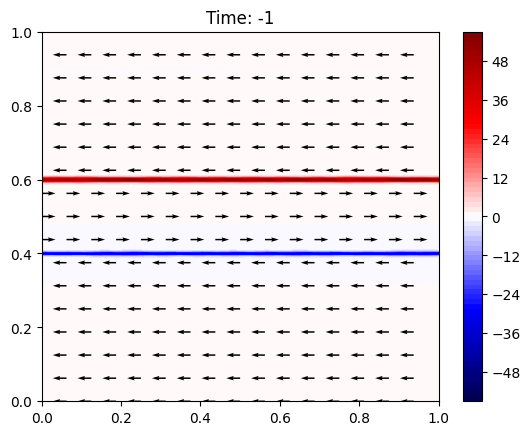

In [25]:
plot(MPS_U_quimb, MPS_V_quimb, save_path="/Users/q556220/Projekte/MPS encoding/test/test.png")

In [26]:
def hadamard_product(a_MPS, b_MPS, chi):
    phys_dim = a_MPS.phys_dim(0)    # get the size of each physical index
    k_delta = np.zeros((phys_dim, phys_dim, phys_dim))  # initialize kronecker delta as np.array
    for i in range(phys_dim):
        k_delta[i, i, i] = 1    # only set variables to one where each index is the same
    temp_MPS = a_MPS
    for i in range(temp_MPS.L):
        delta = qu.tensor.Tensor(k_delta, inds=(f'k{i}', f'a{i}', f'b{i}'), tags=f'I{i}')   # create a kronecker delta tensor for each individual leg of the MPS
        temp_MPS = temp_MPS & delta     # connect kronecker delta tensor to MPS
        temp_MPS = temp_MPS ^ f'I{i}'   # contract kronecker delta tensor to MPS

    data = list(temp_MPS.arrays)    # convert TN to list of np.arrays in order to convert it to quimb MPO
    data[0] = data[0].transpose((1, 2, 0))   # reorder indices for first tensor (quimb speciality)
    result_MPO = qu.tensor.MatrixProductOperator(data, shape='dulr')    # create quimb MPO
    result_MPO.compress(max_bond=chi)
    b_MPS.compress(max_bond=chi)
    
    return result_MPO.apply(b_MPS, compress=True, max_bond=chi)  # return the MPO applied to the other MPS

In [24]:
def hadamard_product_MPO(a_MPS, chi):
    phys_dim = a_MPS.phys_dim(0)    # get the size of each physical index
    k_delta = np.zeros((phys_dim, phys_dim, phys_dim))  # initialize kronecker delta as np.array
    for i in range(phys_dim):
        k_delta[i, i, i] = 1    # only set variables to one where each index is the same
    temp_MPS = a_MPS.copy()
    for i in range(temp_MPS.L):
        delta = qu.tensor.Tensor(k_delta, inds=(f'k{i}', f'a{i}', f'b{i}'), tags=f'I{i}')   # create a kronecker delta tensor for each individual leg of the MPS
        temp_MPS = temp_MPS & delta     # connect kronecker delta tensor to MPS
        temp_MPS = temp_MPS ^ f'I{i}'   # contract kronecker delta tensor to MPS

    data = list(temp_MPS.arrays)    # convert TN to list of np.arrays in order to convert it to quimb MPO
    data[0] = data[0].transpose((1, 2, 0))   # reorder indices for first tensor (quimb speciality)
    result_MPO = qu.tensor.MatrixProductOperator(data, shape='dulr')    # create quimb MPO
    # result_MPO.compress(max_bond=chi)
    result_MPO.compress()
    
    return result_MPO   # return the MPO

In [25]:
def get_precontracted_LR_mps_mps(mps_2, mps_1, center=0):
    n = mps_1.L
    left_networks = [None]*n
    right_networks = [None]*n

    # handle boundary networks
    dummy_t = qu.tensor.Tensor(np.ones((1, 1)), ('A', 'B'))
    left_networks[0] = dummy_t.copy()
    right_networks[-1] = dummy_t.copy()

    # from left to right
    for i in range(center):
        if i == 0:
            A = mps_1[0].copy()
            B = mps_2[0].copy()

            tn = A | B
            qu.tensor.connect(A, B, 1, 1)
            F = tn ^...

        elif i == n-1:
            A = mps_1[n-1].copy()
            B = mps_2[n-1].copy()
            F = F.copy()
            
            tn = A | F
            qu.tensor.connect(A, F, 0, 0)
            AF = tn ^ ...
            tn = AF | B
            qu.tensor.connect(AF, B, 0, 1)
            qu.tensor.connect(AF, B, 1, 0)
            F = tn ^...
        
        else:
            A = mps_1[i].copy()
            B = mps_2[i].copy()
            F = F.copy()

            tn = A | F
            qu.tensor.connect(A, F, 0, 0)
            AF = tn ^ ...
            tn = AF | B
            qu.tensor.connect(AF, B, 1, 2)
            qu.tensor.connect(AF, B, 2, 0)
            F = tn ^ ...
        
        left_networks[i+1] = F
    
    # from right to left
    for i in range(n-1, center, -1):
        if i == n-1:
            A = mps_1[n-1].copy()
            B = mps_2[n-1].copy()

            tn = A | B 
            qu.tensor.connect(A, B, 1, 1)
            F = tn ^...


        elif i == 0:
            A = mps_1[0].copy()
            B = mps_2[0].copy()
            F = F.copy()

            tn = A | F
            qu.tensor.connect(A, F, 0, 0)
            AF = tn ^ ...
            tn = AF | B
            qu.tensor.connect(AF, B, 0, 1)
            qu.tensor.connect(AF, B, 1, 0)      
            F = tn ^...
        
        else:
            A = mps_1[i].copy()
            B = mps_2[i].copy()
            F = F.copy()

            tn = A | F
            qu.tensor.connect(A, F, 1, 0)
            AF = tn ^ ...
            tn = AF | B
            qu.tensor.connect(AF, B, 1, 2)
            qu.tensor.connect(AF, B, 2, 1)
            F = tn ^...
        
        right_networks[i-1] = F

    return left_networks, right_networks

In [26]:
def get_precontracted_LR_mps_mpo(mps_2, mpo, mps_1, center=0):
    n = mps_1.L
    left_networks = [None]*n
    right_networks = [None]*n

    # handle boundary networks
    dummy_t = qu.tensor.Tensor(np.ones((1, 1, 1)), ('A', 'W', 'B'))
    left_networks[0] = dummy_t.copy()
    right_networks[-1] = dummy_t.copy()

    # from left to right
    for i in range(center):
        if i == 0:
            A = mps_1[0].copy()
            B = mps_2[0].copy()
            W = mpo[0].copy()

            tn = A | W 
            qu.tensor.connect(A, W, 1, 1)
            AW = tn ^ ...
            tn = AW | B
            qu.tensor.connect(AW, B, 2, 1)
            F = tn ^...

        elif i == n-1:
            A = mps_1[n-1].copy()
            B = mps_2[n-1].copy()
            W = mpo[n-1].copy()
            F = F.copy()

            tn = A | F
            qu.tensor.connect(A, F, 0, 0)
            AF = tn ^ ...
            tn = AF | W
            qu.tensor.connect(AF, W, 0, 1)
            qu.tensor.connect(AF, W, 1, 0)
            FAW = tn ^...
            tn = FAW | B
            qu.tensor.connect(FAW, B, 1, 1)
            qu.tensor.connect(FAW, B, 0, 0)
            F = tn ^...
        
        else:
            A = mps_1[i].copy()
            B = mps_2[i].copy()
            W = mpo[i].copy()
            F = F.copy()

            tn = A | F
            qu.tensor.connect(A, F, 0, 0)
            AF = tn ^ ...
            tn = AF | W
            qu.tensor.connect(AF, W, 1, 2)
            qu.tensor.connect(AF, W, 2, 0)
            FAW = tn ^ ...
            tn = FAW | B
            qu.tensor.connect(FAW, B, 3, 2)
            qu.tensor.connect(FAW, B, 1, 0)
            F = tn ^...
        
        left_networks[i+1] = F

    # from right to left
    for i in range(n-1, center, -1):
        if i == n-1:
            A = mps_1[n-1].copy()
            B = mps_2[n-1].copy()
            W = mpo[n-1].copy()

            tn = A | W 
            qu.tensor.connect(A, W, 1, 1)
            AW = tn ^ ...
            tn = AW | B
            qu.tensor.connect(AW, B, 2, 1)
            F = tn ^...

        elif i == 0:
            A = mps_1[0].copy()
            B = mps_2[0].copy()
            W = mpo[0].copy()
            F = F.copy()

            tn = A | F
            qu.tensor.connect(A, F, 0, 0)
            AF = tn ^ ...
            tn = AF | W
            qu.tensor.connect(AF, W, 0, 1)
            qu.tensor.connect(AF, W, 1, 0)
            FAW = tn ^...
            tn = FAW | B
            qu.tensor.connect(FAW, B, 1, 1)
            qu.tensor.connect(FAW, B, 0, 0)
            F = tn ^...
        
        else:
            A = mps_1[i].copy()
            B = mps_2[i].copy()
            W = mpo[i].copy()
            F = F.copy()

            tn = A | F
            qu.tensor.connect(A, F, 1, 0)
            AF = tn ^ ...
            tn = AF | W
            qu.tensor.connect(AF, W, 1, 2)
            qu.tensor.connect(AF, W, 2, 1)
            FAW = tn ^ ...
            tn = FAW | B
            qu.tensor.connect(FAW, B, 3, 2)
            qu.tensor.connect(FAW, B, 1, 1)
            F = tn ^...
        
        right_networks[i-1] = F

    return left_networks, right_networks

In [38]:
def update_precontracted_LR_mps_mpo(F, B, W, A, LR):
    A = A.copy()
    B = B.copy()
    W = W.copy()
    F = F.copy()

    if LR == 'L':
        tn = A | F
        qu.tensor.connect(A, F, 0, 0)
        AF = tn ^ ...
        tn = AF | W
        qu.tensor.connect(AF, W, 1, 2)
        qu.tensor.connect(AF, W, 2, 0)
        FAW = tn ^ ...
        tn = FAW | B
        qu.tensor.connect(FAW, B, 3, 2)
        qu.tensor.connect(FAW, B, 1, 0)
        F = tn ^...

    elif LR == 'R':
        tn = A | F
        qu.tensor.connect(A, F, 1, 0)
        AF = tn ^ ...
        tn = AF | W
        qu.tensor.connect(AF, W, 1, 2)
        qu.tensor.connect(AF, W, 2, 1)
        FAW = tn ^ ...
        tn = FAW | B
        qu.tensor.connect(FAW, B, 3, 2)
        qu.tensor.connect(FAW, B, 1, 1)
        F = tn ^...
    
    return F

In [28]:
def update_precontracted_LR_mps_mps(F, B, A, LR):
    A = A.copy()
    B = B.copy()
    F = F.copy()

    if LR == 'L':
        tn = A | F
        qu.tensor.connect(A, F, 0, 0)
        AF = tn ^ ...
        tn = AF | B
        qu.tensor.connect(AF, B, 1, 2)
        qu.tensor.connect(AF, B, 2, 0)
        F = tn ^ ...
    elif LR == 'R':
        tn = A | F
        qu.tensor.connect(A, F, 1, 0)
        AF = tn ^ ...
        tn = AF | B
        qu.tensor.connect(AF, B, 1, 2)
        qu.tensor.connect(AF, B, 2, 1)
        F = tn ^...
    
    return F

In [29]:
def extract_tensor(tn, i):
    if i == 0:
        tensor = tn[0].copy()
        tensor.new_ind('dummy', 1, 0)
    elif i == tn.L-1:
        tensor = tn[-1].copy()
        tensor.new_ind('dummy', 1, 1)
    else:
        tensor = tn[i].copy()
    
    return tensor

In [30]:
def copy_mps(MPS):
    return qu.tensor.MatrixProductState(MPS.arrays)

In [31]:
def cost_function(U, V, Ax_MPS, Ay_MPS, Bx_MPS, By_MPS, chi, dt, t, Re, mu, n, dx):
    d1x = Diff_1_8_x_MPO(n, dx)
    d1y = Diff_1_8_y_MPO(n, dx)
    d2x = Diff_2_8_x_MPO(n, dx)
    d2y = Diff_2_8_y_MPO(n, dx)

    d1x_d1x = d1x.apply(d1x, compress=True)
    d1x_d1y = d1x.apply(d1y, compress=True)
    d1y_d1y = d1y.apply(d1y, compress=True)
    
    # create MPOs for convection-diffusion terms
    Bx_MPO = hadamard_product_MPO(copy_mps(Bx_MPS), chi)
    Bxd1x = Bx_MPO.apply(d1x, compress=True)
    d1xBx = d1x.apply(Bx_MPO, compress=True)
    By_MPO = hadamard_product_MPO(copy_mps(By_MPS), chi)
    Byd1y = By_MPO.apply(d1y, compress=True)
    d1yBy = d1y.apply(By_MPO, compress=True)

    cost_c = 0

    # continuity equation
    continuity_state = (d1x.apply(U, compress=True, max_bond=chi) + d1y.apply(V, compress=True, max_bond=chi))
    cost_c += mu * (continuity_state.H @ continuity_state)

    cost_m = 0

    # momentum equation for x
    momentum_x = (U-Ax_MPS)/dt
    momentum_x += 0.5 * Bxd1x.apply(Bx_MPS, compress=True, max_bond=chi)
    momentum_x += 0.5 * d1xBx.apply(Bx_MPS, compress=True, max_bond=chi)
    momentum_x += 0.5 * Byd1y.apply(Bx_MPS, compress=True, max_bond=chi)
    momentum_x += 0.5 * d1yBy.apply(Bx_MPS, compress=True, max_bond=chi)
    momentum_x += -1/Re * d2x.apply(Bx_MPS, compress=True, max_bond=chi)
    momentum_x += -1/Re * d2y.apply(Bx_MPS, compress=True, max_bond=chi)

    cost_m += momentum_x.H @ momentum_x

    # momentum equation for y
    momentum_y = (V-Ay_MPS)/dt
    momentum_y += 0.5 * Bxd1x.apply(By_MPS, compress=True, max_bond=chi)
    momentum_y += 0.5 * d1xBx.apply(By_MPS, compress=True, max_bond=chi)
    momentum_y += 0.5 * Byd1y.apply(By_MPS, compress=True, max_bond=chi)
    momentum_y += 0.5 * d1yBy.apply(By_MPS, compress=True, max_bond=chi)
    momentum_y += -1/Re * d2x.apply(By_MPS, compress=True, max_bond=chi)
    momentum_y += -1/Re * d2y.apply(By_MPS, compress=True, max_bond=chi)

    cost_m += momentum_y.H @ momentum_y

    return cost_c+cost_m, cost_c, cost_m

In [40]:
def single_time_step(U, V, Ax_MPS, Ay_MPS, Bx_MPS, By_MPS, chi, dt, Re, mu, d1x, d1y, d2x, d2y, d1x_d1x, d1x_d1y, d1y_d1y, U_d1x_d1x_U_left, U_d1x_d1x_U_right, U_d1x_d1y_V_left, U_d1x_d1y_V_right, V_d1y_d1y_V_left, V_d1y_d1y_V_right):
    # initialize precontracted left and right networks
    U_Ax_left, U_Ax_right = get_precontracted_LR_mps_mps(U, Ax_MPS)
    V_Ay_left, V_Ay_right = get_precontracted_LR_mps_mps(V, Ay_MPS)

    n = U.L                     # size of MPS
    dx = 1 / (2**n - 1)

    # create MPOs for convection-diffusion terms
    Bx_MPO = hadamard_product_MPO(copy_mps(Bx_MPS), chi)
    Bxd1x = Bx_MPO.apply(d1x, compress=True)
    d1xBx = d1x.apply(Bx_MPO, compress=True)
    By_MPO = hadamard_product_MPO(copy_mps(By_MPS), chi)
    Byd1y = By_MPO.apply(d1y, compress=True)
    d1yBy = d1y.apply(By_MPO, compress=True)

    # convection-diffusion terms for x direction (prefactors not included)
    U_d2x_Bx_left, U_d2x_Bx_right = get_precontracted_LR_mps_mpo(U, d2x, Bx_MPS)
    U_d2y_Bx_left, U_d2y_Bx_right = get_precontracted_LR_mps_mpo(U, d2y, Bx_MPS)
    U_Bxd1x_Bx_left, U_Bxd1x_Bx_right = get_precontracted_LR_mps_mpo(U, Bxd1x, Bx_MPS)
    U_d1xBx_Bx_left, U_d1xBx_Bx_right = get_precontracted_LR_mps_mpo(U, d1xBx, Bx_MPS)
    U_Byd1y_Bx_left, U_Byd1y_Bx_right = get_precontracted_LR_mps_mpo(U, Byd1y, Bx_MPS)
    U_d1yBy_Bx_left, U_d1yBy_Bx_right = get_precontracted_LR_mps_mpo(U, d1yBy, Bx_MPS)

    # convection-diffusion terms for y direction (prefactors not included)
    V_d2x_By_left, V_d2x_By_right = get_precontracted_LR_mps_mpo(V, d2x, By_MPS)
    V_d2y_By_left, V_d2y_By_right = get_precontracted_LR_mps_mpo(V, d2y, By_MPS)
    V_Bxd1x_By_left, V_Bxd1x_By_right = get_precontracted_LR_mps_mpo(V, Bxd1x, By_MPS)
    V_d1xBx_By_left, V_d1xBx_By_right = get_precontracted_LR_mps_mpo(V, d1xBx, By_MPS)
    V_Byd1y_By_left, V_Byd1y_By_right = get_precontracted_LR_mps_mpo(V, Byd1y, By_MPS)
    V_d1yBy_By_left, V_d1yBy_By_right = get_precontracted_LR_mps_mpo(V, d1yBy, By_MPS)

    epsilon = 1e-6              # convergence criterion
    E_0 = 1e-10                 # Energy before
    E_1 = 2*epsilon             # Energy after

    # helper function to compute convection-diffusion terms
    def conv_diff(left_tn, right_tn, A_t, W_t):
        left_tn = left_tn.copy()
        right_tn = right_tn.copy()
        A_t = A_t.copy()
        W_t = W_t.copy()
        tn = left_tn | A_t | W_t | right_tn
        qu.tensor.connect(left_tn, A_t, 0, 0)
        qu.tensor.connect(right_tn, A_t, 0, 1)
        qu.tensor.connect(W_t, A_t, 3, 2)
        qu.tensor.connect(W_t, left_tn, 0, 1)
        qu.tensor.connect(W_t, right_tn, 1, 1)
        temp = tn^...
        temp = temp.fuse({'LRD': (temp.inds[0], temp.inds[2], temp.inds[1])}).data

        return temp
    
    def H_terms(left_tn, right_tn, W_t):
        left_tn = left_tn.copy()
        right_tn = right_tn.copy()
        W_t = W_t.copy()
        tn = left_tn | W_t | right_tn
        qu.tensor.connect(W_t, left_tn, 0, 1)
        qu.tensor.connect(W_t, right_tn, 1, 1)
        temp = tn^...
        temp = temp.fuse({'LRD': (temp.inds[1], temp.inds[5], temp.inds[3]), 'MSU': (temp.inds[0], temp.inds[4], temp.inds[2])}).data

        return temp

    run = 0
    while np.abs((E_1-E_0)/E_0) > epsilon:      # do until the energy does not change anymore
        U_trial = U.copy()
        V_trial = V.copy()
        U_trial.right_canonize()
        V_trial.right_canonize()
        run += 1

        # sweep through MPS and optimize locally
        for i in range(n-1):      
            # Build linear system Ax = b 
            # Prepare individual tensor nodes
            Ax_MPS_i = extract_tensor(Ax_MPS, i)
            Ay_MPS_i = extract_tensor(Ay_MPS, i)
            Bx_MPS_i = extract_tensor(Bx_MPS, i)
            By_MPS_i = extract_tensor(By_MPS, i)
            d2x_i = extract_tensor(d2x, i)
            d2y_i = extract_tensor(d2y, i)
            Bxd1x_i = extract_tensor(Bxd1x, i)
            d1xBx_i = extract_tensor(d1xBx, i)
            Byd1y_i = extract_tensor(Byd1y, i)
            d1yBy_i = extract_tensor(d1yBy, i)
            d1x_d1x_i = extract_tensor(d1x_d1x, i)
            d1x_d1y_i = extract_tensor(d1x_d1y, i)
            d1y_d1y_i = extract_tensor(d1y_d1y, i)

            # b_1
            left_tn = U_Ax_left[i].copy()
            right_tn = U_Ax_right[i].copy()
            A_t = Ax_MPS_i.copy() 
            # x_1 = A_t.data.transpose((0, 2, 1)).flatten()
            tn = left_tn | A_t | right_tn
            qu.tensor.connect(left_tn, A_t, 0, 0)
            qu.tensor.connect(right_tn, A_t, 0, 1)
            b_1 = tn ^...
            b_1 = b_1.fuse({'LRD': (b_1.inds[0], b_1.inds[2], b_1.inds[1])}).data

            # convection-diffusion terms
            b_1 += dt/Re * conv_diff(U_d2x_Bx_left[i], U_d2x_Bx_right[i], Bx_MPS_i, d2x_i)
            b_1 += dt/Re * conv_diff(U_d2y_Bx_left[i], U_d2y_Bx_right[i], Bx_MPS_i, d2y_i)
            b_1 += -dt/2 * conv_diff(U_Bxd1x_Bx_left[i], U_Bxd1x_Bx_right[i], Bx_MPS_i, Bxd1x_i)
            b_1 += -dt/2 * conv_diff(U_d1xBx_Bx_left[i], U_d1xBx_Bx_right[i], Bx_MPS_i, d1xBx_i)
            b_1 += -dt/2 * conv_diff(U_Byd1y_Bx_left[i], U_Byd1y_Bx_right[i], Bx_MPS_i, Byd1y_i)
            b_1 += -dt/2 * conv_diff(U_d1yBy_Bx_left[i], U_d1yBy_Bx_right[i], Bx_MPS_i, d1yBy_i)

            # b_2
            left_tn = V_Ay_left[i].copy()
            right_tn = V_Ay_right[i].copy()
            A_t = Ay_MPS_i.copy()
            # x_2 = A_t.data.transpose((0, 2, 1)).flatten()
            tn = left_tn | A_t | right_tn
            qu.tensor.connect(left_tn, A_t, 0, 0)
            qu.tensor.connect(right_tn, A_t, 0, 1)
            b_2 = tn ^...
            b_2 = b_2.fuse({'LRD': (b_2.inds[0], b_2.inds[2], b_2.inds[1])}).data

            # convection-diffusion terms
            b_2 += dt/Re * conv_diff(V_d2x_By_left[i], V_d2x_By_right[i], By_MPS_i, d2x_i)
            b_2 += dt/Re * conv_diff(V_d2y_By_left[i], V_d2y_By_right[i], By_MPS_i, d2y_i)
            b_2 += -dt/2 * conv_diff(V_Bxd1x_By_left[i], V_Bxd1x_By_right[i], By_MPS_i, Bxd1x_i)
            b_2 += -dt/2 * conv_diff(V_d1xBx_By_left[i], V_d1xBx_By_right[i], By_MPS_i, d1xBx_i)
            b_2 += -dt/2 * conv_diff(V_Byd1y_By_left[i], V_Byd1y_By_right[i], By_MPS_i, Byd1y_i)
            b_2 += -dt/2 * conv_diff(V_d1yBy_By_left[i], V_d1yBy_By_right[i], By_MPS_i, d1yBy_i)

            # H matrix terms
            H_11 = H_terms(U_d1x_d1x_U_left[i], U_d1x_d1x_U_right[i], d1x_d1x_i)
            H_12 = H_terms(U_d1x_d1y_V_left[i], U_d1x_d1y_V_right[i], d1x_d1y_i)
            H_22 = H_terms(V_d1y_d1y_V_left[i], V_d1y_d1y_V_right[i], d1y_d1y_i)

            # np.save(f"/Users/q556220/dev/TN_CFD/2D_TDJ/H/H_11_{i}.npy", H_11)
            # np.save(f"/Users/q556220/dev/TN_CFD/2D_TDJ/H/H_12_{i}.npy", H_12)
            # np.save(f"/Users/q556220/dev/TN_CFD/2D_TDJ/H/H_22_{i}.npy", H_22)

            H = np.block([[H_11, H_12], [H_12.T, H_22]])
            A = np.eye(len(H)) - mu*dt**2 * H
            b = np.concatenate((b_1, b_2))

            # x_init = np.concatenate((x_1, x_2))

            # solve using conjugate gradient
            # x, _ = cg(A, b, x_init)
            # print(np.all(np.linalg.eigvals(A) > 0))
            x = np.linalg.solve(A,b)
            U_new, V_new = np.array_split(x, 2)
            
            # update MPSs and precontracted networks
            # update MPS
            shape = U_trial[i].shape
            U_trial_data = list(U_trial.arrays)
            U_trial_data[i] = U_new.reshape(shape)
            U_trial = qu.tensor.MatrixProductState(U_trial_data, shape='lrp')
            V_trial_data = list(V_trial.arrays)
            V_trial_data[i] = V_new.reshape(shape)
            V_trial = qu.tensor.MatrixProductState(V_trial_data, shape='lrp')
            
            # cost, cost_c, cost_m = cost_function(U_trial, V_trial, Ax_MPS, Ay_MPS, Bx_MPS, By_MPS, chi, dt, 0, Re, mu, n, dx)
            # print(cost, cost_c, cost_m)

            # shift canonical center 
            U_trial.shift_orthogonality_center(i, i+1)
            V_trial.shift_orthogonality_center(i, i+1)

            # Extract tensor nodes
            U_trial_i = extract_tensor(U_trial, i)
            U_trial_i_copy = extract_tensor(copy_mps(U_trial), i)
            V_trial_i = extract_tensor(V_trial, i)
            V_trial_i_copy = extract_tensor(copy_mps(V_trial), i)
            # update precontracted networks
            U_Ax_left[i+1] = update_precontracted_LR_mps_mps(U_Ax_left[i], U_trial_i, Ax_MPS_i, 'L')
            V_Ay_left[i+1] = update_precontracted_LR_mps_mps(V_Ay_left[i], V_trial_i, Ay_MPS_i, 'L')

            U_d2x_Bx_left[i+1] = update_precontracted_LR_mps_mpo(U_d2x_Bx_left[i], U_trial_i, d2x_i, Bx_MPS_i, 'L')
            U_d2y_Bx_left[i+1] = update_precontracted_LR_mps_mpo(U_d2y_Bx_left[i], U_trial_i, d2y_i, Bx_MPS_i, 'L')
            U_Bxd1x_Bx_left[i+1] = update_precontracted_LR_mps_mpo(U_Bxd1x_Bx_left[i], U_trial_i, Bxd1x_i, Bx_MPS_i, 'L')
            U_d1xBx_Bx_left[i+1] = update_precontracted_LR_mps_mpo(U_d1xBx_Bx_left[i], U_trial_i, d1xBx_i, Bx_MPS_i, 'L')
            U_Byd1y_Bx_left[i+1] = update_precontracted_LR_mps_mpo(U_Byd1y_Bx_left[i], U_trial_i, Byd1y_i, Bx_MPS_i, 'L')
            U_d1yBy_Bx_left[i+1] = update_precontracted_LR_mps_mpo(U_d1yBy_Bx_left[i], U_trial_i, d1yBy_i, Bx_MPS_i, 'L')

            V_d2x_By_left[i+1] = update_precontracted_LR_mps_mpo(V_d2x_By_left[i], V_trial_i, d2x_i, By_MPS_i, 'L')
            V_d2y_By_left[i+1] = update_precontracted_LR_mps_mpo(V_d2y_By_left[i], V_trial_i, d2y_i, By_MPS_i, 'L')
            V_Bxd1x_By_left[i+1] = update_precontracted_LR_mps_mpo(V_Bxd1x_By_left[i], V_trial_i, Bxd1x_i, By_MPS_i, 'L')
            V_d1xBx_By_left[i+1] = update_precontracted_LR_mps_mpo(V_d1xBx_By_left[i], V_trial_i, d1xBx_i, By_MPS_i, 'L')
            V_Byd1y_By_left[i+1] = update_precontracted_LR_mps_mpo(V_Byd1y_By_left[i], V_trial_i, Byd1y_i, By_MPS_i, 'L')
            V_d1yBy_By_left[i+1] = update_precontracted_LR_mps_mpo(V_d1yBy_By_left[i], V_trial_i, d1yBy_i, By_MPS_i, 'L')

            U_d1x_d1x_U_left[i+1] = update_precontracted_LR_mps_mpo(U_d1x_d1x_U_left[i], U_trial_i, d1x_d1x_i, U_trial_i_copy, 'L')
            U_d1x_d1y_V_left[i+1] = update_precontracted_LR_mps_mpo(U_d1x_d1y_V_left[i], U_trial_i, d1x_d1y_i, V_trial_i, 'L')
            V_d1y_d1y_V_left[i+1] = update_precontracted_LR_mps_mpo(V_d1y_d1y_V_left[i], V_trial_i, d1y_d1y_i, V_trial_i_copy, 'L')
        
        # sweep back through MPS and optimize locally
        for i in range(n-1, 0, -1):
            # Build linear system Ax = b 
            # Prepare individual tensor nodes
            Ax_MPS_i = extract_tensor(Ax_MPS, i)
            Ay_MPS_i = extract_tensor(Ay_MPS, i)
            Bx_MPS_i = extract_tensor(Bx_MPS, i)
            By_MPS_i = extract_tensor(By_MPS, i)
            d2x_i = extract_tensor(d2x, i)
            d2y_i = extract_tensor(d2y, i)
            Bxd1x_i = extract_tensor(Bxd1x, i)
            d1xBx_i = extract_tensor(d1xBx, i)
            Byd1y_i = extract_tensor(Byd1y, i)
            d1yBy_i = extract_tensor(d1yBy, i)
            d1x_d1x_i = extract_tensor(d1x_d1x, i)
            d1x_d1y_i = extract_tensor(d1x_d1y, i)
            d1y_d1y_i = extract_tensor(d1y_d1y, i)

            # b_1
            left_tn = U_Ax_left[i].copy()
            # print(left_tn)
            right_tn = U_Ax_right[i].copy()
            # print(right_tn)
            A_t = Ax_MPS_i.copy() 
            # x_1 = A_t.data.transpose((0, 2, 1)).flatten()
            # print(A_t)
            tn = left_tn | A_t | right_tn
            qu.tensor.connect(left_tn, A_t, 0, 0)
            qu.tensor.connect(right_tn, A_t, 0, 1)
            # print(tn)
            b_1 = tn ^...
            b_1 = b_1.fuse({'LRD': (b_1.inds[0], b_1.inds[2], b_1.inds[1])}).data

            # convection-diffusion terms
            b_1 += dt/Re * conv_diff(U_d2x_Bx_left[i], U_d2x_Bx_right[i], Bx_MPS_i, d2x_i)
            b_1 += dt/Re * conv_diff(U_d2y_Bx_left[i], U_d2y_Bx_right[i], Bx_MPS_i, d2y_i)
            b_1 += -dt/2 * conv_diff(U_Bxd1x_Bx_left[i], U_Bxd1x_Bx_right[i], Bx_MPS_i, Bxd1x_i)
            b_1 += -dt/2 * conv_diff(U_d1xBx_Bx_left[i], U_d1xBx_Bx_right[i], Bx_MPS_i, d1xBx_i)
            b_1 += -dt/2 * conv_diff(U_Byd1y_Bx_left[i], U_Byd1y_Bx_right[i], Bx_MPS_i, Byd1y_i)
            b_1 += -dt/2 * conv_diff(U_d1yBy_Bx_left[i], U_d1yBy_Bx_right[i], Bx_MPS_i, d1yBy_i)

            # b_2
            left_tn = V_Ay_left[i].copy()
            right_tn = V_Ay_right[i].copy()
            A_t = Ay_MPS_i.copy()
            # x_2 = A_t.data.transpose((0, 2, 1)).flatten()
            tn = left_tn | A_t | right_tn
            qu.tensor.connect(left_tn, A_t, 0, 0)
            qu.tensor.connect(right_tn, A_t, 0, 1)
            b_2 = tn ^...
            b_2 = b_2.fuse({'LRD': (b_2.inds[0], b_2.inds[2], b_2.inds[1])}).data

            # convection-diffusion terms
            b_2 += dt/Re * conv_diff(V_d2x_By_left[i], V_d2x_By_right[i], By_MPS_i, d2x_i)
            b_2 += dt/Re * conv_diff(V_d2y_By_left[i], V_d2y_By_right[i], By_MPS_i, d2y_i)
            b_2 += -dt/2 * conv_diff(V_Bxd1x_By_left[i], V_Bxd1x_By_right[i], By_MPS_i, Bxd1x_i)
            b_2 += -dt/2 * conv_diff(V_d1xBx_By_left[i], V_d1xBx_By_right[i], By_MPS_i, d1xBx_i)
            b_2 += -dt/2 * conv_diff(V_Byd1y_By_left[i], V_Byd1y_By_right[i], By_MPS_i, Byd1y_i)
            b_2 += -dt/2 * conv_diff(V_d1yBy_By_left[i], V_d1yBy_By_right[i], By_MPS_i, d1yBy_i)

            # H matrix terms
            H_11 = H_terms(U_d1x_d1x_U_left[i], U_d1x_d1x_U_right[i], d1x_d1x_i)
            H_12 = H_terms(U_d1x_d1y_V_left[i], U_d1x_d1y_V_right[i], d1x_d1y_i)
            H_22 = H_terms(V_d1y_d1y_V_left[i], V_d1y_d1y_V_right[i], d1y_d1y_i)

            H = mu*dt**2 * np.block([[H_11, H_12], [H_12.T, H_22]])
            A = np.eye(len(H)) - H

            # print(np.all(np.linalg.eigvals(A) > 0))
            b = np.concatenate((b_1, b_2))
            # x_init = np.concatenate((x_1, x_2))

            # solve using conjugate gradient
            # x, _ = cg(A, b, x_init)
            x = np.linalg.solve(A,b)
            U_new, V_new = np.array_split(x, 2)
            
            # update MPSs and precontracted networks
            # update MPS
            shape = U_trial[i].shape
            U_trial_data = list(U_trial.arrays)
            U_trial_data[i] = U_new.reshape(shape)
            U_trial = qu.tensor.MatrixProductState(U_trial_data, shape='lrp')
            V_trial_data = list(V_trial.arrays)
            V_trial_data[i] = V_new.reshape(shape)
            V_trial = qu.tensor.MatrixProductState(V_trial_data, shape='lrp')
            
            # cost, cost_c, cost_m = cost_function(U_trial, V_trial, Ax_MPS, Ay_MPS, Bx_MPS, By_MPS, chi, dt, 0, Re, mu, n, dx)
            # print(cost, cost_c, cost_m)

            # shift canonical center 
            U_trial.shift_orthogonality_center(i, i-1)
            V_trial.shift_orthogonality_center(i, i-1)

            # Extract tensor nodes
            U_trial_i = extract_tensor(U_trial, i)
            U_trial_i_copy = extract_tensor(copy_mps(U_trial), i)
            V_trial_i = extract_tensor(V_trial, i)
            V_trial_i_copy = extract_tensor(copy_mps(V_trial), i)
            # update precontracted networks
            U_Ax_right[i-1] = update_precontracted_LR_mps_mps(U_Ax_right[i], U_trial_i, Ax_MPS_i, 'R')
            V_Ay_right[i-1] = update_precontracted_LR_mps_mps(V_Ay_right[i], V_trial_i, Ay_MPS_i, 'R')

            U_d2x_Bx_right[i-1] = update_precontracted_LR_mps_mpo(U_d2x_Bx_right[i], U_trial_i, d2x_i, Bx_MPS_i, 'R')
            U_d2y_Bx_right[i-1] = update_precontracted_LR_mps_mpo(U_d2y_Bx_right[i], U_trial_i, d2y_i, Bx_MPS_i, 'R')
            U_Bxd1x_Bx_right[i-1] = update_precontracted_LR_mps_mpo(U_Bxd1x_Bx_right[i], U_trial_i, Bxd1x_i, Bx_MPS_i, 'R')
            U_d1xBx_Bx_right[i-1] = update_precontracted_LR_mps_mpo(U_d1xBx_Bx_right[i], U_trial_i, d1xBx_i, Bx_MPS_i, 'R')
            U_Byd1y_Bx_right[i-1] = update_precontracted_LR_mps_mpo(U_Byd1y_Bx_right[i], U_trial_i, Byd1y_i, Bx_MPS_i, 'R')
            U_d1yBy_Bx_right[i-1] = update_precontracted_LR_mps_mpo(U_d1yBy_Bx_right[i], U_trial_i, d1yBy_i, Bx_MPS_i, 'R')

            V_d2x_By_right[i-1] = update_precontracted_LR_mps_mpo(V_d2x_By_right[i], V_trial_i, d2x_i, By_MPS_i, 'R')
            V_d2y_By_right[i-1] = update_precontracted_LR_mps_mpo(V_d2y_By_right[i], V_trial_i, d2y_i, By_MPS_i, 'R')
            V_Bxd1x_By_right[i-1] = update_precontracted_LR_mps_mpo(V_Bxd1x_By_right[i], V_trial_i, Bxd1x_i, By_MPS_i, 'R')
            V_d1xBx_By_right[i-1] = update_precontracted_LR_mps_mpo(V_d1xBx_By_right[i], V_trial_i, d1xBx_i, By_MPS_i, 'R')
            V_Byd1y_By_right[i-1] = update_precontracted_LR_mps_mpo(V_Byd1y_By_right[i], V_trial_i, Byd1y_i, By_MPS_i, 'R')
            V_d1yBy_By_right[i-1] = update_precontracted_LR_mps_mpo(V_d1yBy_By_right[i], V_trial_i, d1yBy_i, By_MPS_i, 'R')

            U_d1x_d1x_U_right[i-1] = update_precontracted_LR_mps_mpo(U_d1x_d1x_U_right[i], U_trial_i, d1x_d1x_i, U_trial_i_copy, 'R')
            U_d1x_d1y_V_right[i-1] = update_precontracted_LR_mps_mpo(U_d1x_d1y_V_right[i], U_trial_i, d1x_d1y_i, V_trial_i, 'R')
            V_d1y_d1y_V_right[i-1] = update_precontracted_LR_mps_mpo(V_d1y_d1y_V_right[i], V_trial_i, d1y_d1y_i, V_trial_i_copy, 'R')
        
        U = U_trial.copy()
        V = V_trial.copy()
        E_0 = E_1                                        # set the previous "Energy" to E_0
        E_1 = U_trial @ U_trial + V_trial @ V_trial      # calculate the new "Energy" from new states
        print(f"Run: {run}, Diff: {(E_1-E_0)/E_0}, E_0: {E_0}, E_1: {E_1}", end='\r')
    print(f"Run: {run}, Diff: {(E_1-E_0)/E_0}, E_0: {E_0}, E_1: {E_1}", end='\r')
            
    return U.copy(), V.copy()

In [41]:
def time_evolution(U, V, chi, dt, T, Re, mu):   # time evolution algorithm
    n = U.L
    dx = 1 / (2**n - 1)
    n_steps = int(np.ceil(T/dt))    # time steps
    # finite difference operators with 8th order precision
    d1x = Diff_1_8_x_MPO(n, dx)
    d1y = Diff_1_8_y_MPO(n, dx)
    d2x = Diff_2_8_x_MPO(n, dx)
    d2y = Diff_2_8_y_MPO(n, dx)

    # finite difference operators with 2nd order precision 
    # d1x = Diff_1_2_x_MPO(n, dx)
    # d1y = Diff_1_2_y_MPO(n, dx)
    # d2x = Diff_2_2_x_MPO(n, dx)
    # d2y = Diff_2_2_y_MPO(n, dx)

    d1x_d1x = d1x.apply(d1x, compress=True)
    d1x_d1y = d1x.apply(d1y, compress=True)
    d1y_d1y = d1y.apply(d1y, compress=True)
    
    # bring the orthogonality center to the first tensor
    U.right_canonize()
    V.right_canonize()

    # initialize precontracted left and right networks
    U_d1x_d1x_U_left, U_d1x_d1x_U_right = get_precontracted_LR_mps_mpo(U, d1x_d1x, copy_mps(U), 0)
    U_d1x_d1y_V_left, U_d1x_d1y_V_right = get_precontracted_LR_mps_mpo(U, d1x_d1y, V, 0)
    V_d1y_d1y_V_left, V_d1y_d1y_V_right = get_precontracted_LR_mps_mpo(V, d1y_d1y, copy_mps(V), 0)

    t = 0
    for step in tqdm(range(n_steps)):   # for every time step dt
        print(f"Step = {step} - Time = {t}", end='\n')
        if step%10 == 0:
            plot(U, V, time=t, save_path=f"/Users/q556220/Projekte/MPS encoding/test_new/step_{step}.png", show=False)

        U_trial = copy_mps(U)          # trial velocity state
        V_trial = copy_mps(V)          # trial velocity state
        U_prev = copy_mps(U)           # previous velocity state
        V_prev = copy_mps(V)           # previous velocity state

        U_prev_copy = copy_mps(U)           # previous velocity state
        V_prev_copy = copy_mps(V)           # previous velocity state

        # Midpoint RK-2 step
        U_mid, V_mid = single_time_step(U_trial, V_trial, U_prev, V_prev, U_prev_copy, V_prev_copy, chi, dt/2, Re, mu, d1x, d1y, d2x, d2y, d1x_d1x, d1x_d1y, d1y_d1y, U_d1x_d1x_U_left, U_d1x_d1x_U_right, U_d1x_d1y_V_left, U_d1x_d1y_V_right, V_d1y_d1y_V_left, V_d1y_d1y_V_right)
        # plot(U_mid, V_mid, full=True, save_path=f"/Users/q556220/Projekte/MPS encoding/test/step_{step}.png")
        # Full RK-2 step
        print('')
        U, V = single_time_step(U_trial, V_trial, U_prev, V_prev, U_mid, V_mid, chi, dt, Re, mu, d1x, d1y, d2x, d2y, d1x_d1x, d1x_d1y, d1y_d1y, U_d1x_d1x_U_left, U_d1x_d1x_U_right, U_d1x_d1y_V_left, U_d1x_d1y_V_right, V_d1y_d1y_V_left, V_d1y_d1y_V_right)
        print('\n')
        t += dt

        np.save(f"/Users/q556220/dev/TN_CFD/2D_TDJ/UV/U_{step}.npy", U.arrays)
        np.save(f"/Users/q556220/dev/TN_CFD/2D_TDJ/UV/V_{step}.npy", V.arrays)
        
        
    return U, V

In [42]:
def build2DExampleMPS(n_bits, L, chi, T): # flexible creation of initial MPS
    # Create field
    N = 2**n_bits

    # Initial conditions
    y_min = 0.4
    y_max = 0.6
    h = 1/200 
    u_max = 1
    epsilon = 10^-8

    # Set timesteps
    dt = 0.1*2**-(n_bits-1)

    # Generate initial fields
    U, V = CreateFields2D(L, N, y_min, y_max, h, u_max) 

    # Rescale into non-dimensional units
    U = U/u_max
    V = V/u_max

    # Convert them to MPS form
    MPS_U = convert_to_MPS2D(U, chi)
    MPS_V = convert_to_MPS2D(V, chi)

    # Tranform into quimb MPS form
    MPS_U_quimb = convert_MPS_to_quimb(MPS_U, 4)
    MPS_V_quimb = convert_MPS_to_quimb(MPS_V, 4)

    return MPS_U_quimb, MPS_V_quimb, MPS_U, MPS_V

In [43]:
# Create field
n_bits = 4
n = n_bits
N = 2**n_bits
L = 1
chi = N

# Set timesteps
dt = 0.1*2**-(n-1)
T = 1

# Set penalty factor for breach of incompressibility condition
dx = 1 / (2**n - 1)
mu = dx**2 * 10**4
# mu = 6.25e4
Re = 200*1e3

In [44]:
U_init, V_init, _, __ = build2DExampleMPS(n_bits, L, chi, T)

  0%|          | 0/80 [00:00<?, ?it/s]

Step = 0 - Time = 0
Run: 2, Diff: 1.554226978769483e-15, E_0: 64.0035106617255, E_1: 64.0035106617256
Run: 2, Diff: 6.661237592390221e-16, E_0: 64.00096611823204, E_1: 64.00096611823209

Step = 1 - Time = 0.0125
Run: 2, Diff: 3.330689661063591e-16, E_0: 63.999604412246754, E_1: 63.999604412246775
Run: 2, Diff: -1.443328694388378e-15, E_0: 63.9982812009123, E_1: 63.99828120091221

Step = 2 - Time = 0.025
Run: 2, Diff: 8.8821897286089e-16, E_0: 63.99707797022104, E_1: 63.9970779702211
Run: 2, Diff: 8.882364048589543e-16, E_0: 63.99582200172751, E_1: 63.99582200172757

Step = 3 - Time = 0.037500000000000006
Run: 2, Diff: 8.882530019835868e-16, E_0: 63.994626231343, E_1: 63.994626231343055
Run: 2, Diff: -2.2206758953168007e-16, E_0: 63.993375823871354, E_1: 63.99337582387134

Step = 4 - Time = 0.05
Run: 2, Diff: 2.22071737628528e-16, E_0: 63.99218048616933, E_1: 63.992180486169346
Run: 2, Diff: -6.662282132267422e-16, E_0: 63.99093178465645, E_1: 63.99093178465641

Step = 5 - Time = 0.0625

KeyboardInterrupt: 

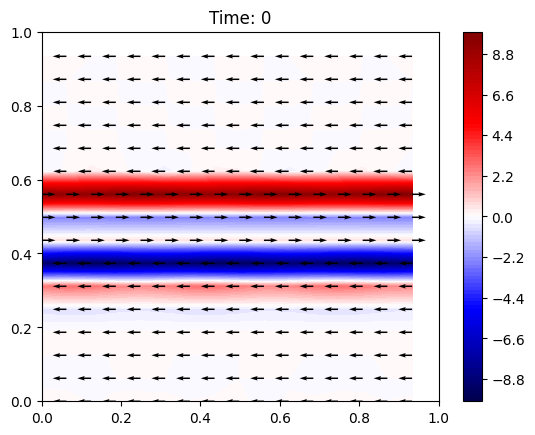

In [45]:
U_test, V_test = time_evolution(U_init, V_init, chi, dt, T, Re, mu)

# Build Matrix A and Vector b manually

In [267]:
U_mps = copy_mps(U_init)
V_mps = copy_mps(V_init)

Ax_mps = copy_mps(U_init)
Ay_mps = copy_mps(V_init)

Bx_mps = copy_mps(U_init)
By_mps = copy_mps(V_init)

d1x = Diff_1_8_x_MPO(n, dx)
d1y = Diff_1_8_y_MPO(n, dx)
d2x = Diff_2_8_x_MPO(n, dx)
d2y = Diff_2_8_y_MPO(n, dx)

d1x_d1x = d1x.apply(d1x, compress=True)
d1x_d1y = d1x.apply(d1y, compress=True)
d1y_d1x = d1y.apply(d1x, compress=True)
d1y_d1y = d1y.apply(d1y, compress=True)

Bx_MPO = hadamard_product_MPO(copy_mps(Bx_mps), chi)
Bxd1x = Bx_MPO.apply(d1x, compress=True)
d1xBx = d1x.apply(Bx_MPO, compress=True)
By_MPO = hadamard_product_MPO(copy_mps(By_mps), chi)
Byd1y = By_MPO.apply(d1y, compress=True)
d1yBy = d1y.apply(By_MPO, compress=True)


In [302]:
# inefficient implementation
def single_time_step(U, V, Ax_MPS, Ay_MPS, Bx_MPS, By_MPS, chi, dt, Re, mu, d1x, d1y, d2x, d2y, d1x_d1x, d1x_d1y, d1y_d1y, U_d1x_d1x_U_left, U_d1x_d1x_U_right, U_d1x_d1y_V_left, U_d1x_d1y_V_right, V_d1y_d1y_V_left, V_d1y_d1y_V_right):
    n = U.L                     # size of MPS
    dx = 1 / (2**n - 1)

    # create MPOs for convection-diffusion terms
    Bx_MPO = hadamard_product_MPO(copy_mps(Bx_MPS), chi)
    Bxd1x = Bx_MPO.apply(d1x, compress=True)
    d1xBx = d1x.apply(Bx_MPO, compress=True)
    By_MPO = hadamard_product_MPO(copy_mps(By_MPS), chi)
    Byd1y = By_MPO.apply(d1y, compress=True)
    d1yBy = d1y.apply(By_MPO, compress=True)

    epsilon = 1e-6              # convergence criterion
    E_0 = 1e-10                 # Energy before
    E_1 = 2*epsilon             # Energy after

    run = 0
    while np.abs((E_1-E_0)/E_0) > epsilon:      # do until the energy does not change anymore
        U_trial = U.copy()
        V_trial = V.copy()
        U_trial.right_canonize()
        V_trial.right_canonize()
        run += 1

        # sweep through MPS and optimize locally
        for i in range(n-1):      
            # Build linear system Ax = b 
            # Prepare individual tensor nodes
            U_mps = copy_mps(U_trial)
            V_mps = copy_mps(V_trial)

            Ax_mps = copy_mps(Ax_MPS)
            Ay_mps = copy_mps(Ay_MPS)

            Bx_mps = copy_mps(Bx_MPS)
            By_mps = copy_mps(By_MPS)
            if i == 0:
                l = 1
                r = U_mps[i].shape[0]
                p = U_mps[i].shape[1]
            else:
                l = U_mps[i].shape[0]
                r = U_mps[i].shape[1]
                p = U_mps[i].shape[2]
            
            H_11 = np.zeros((l*r*p, l*r*p))
            H_12 = np.zeros_like(H_11)
            H_22 = np.zeros_like(H_11)

            b_1 = np.zeros((l*r*p))
            b_2 = np.zeros_like(b_1)
            for L in range(l):
                for R in range(r):
                    for D in range(p):
                        basis = np.zeros((l, r, p))
                        basis[L, R, D] = 1
                        if i == 0:
                            basis = basis.reshape((r, p))
                        U_mps_list = list(U_mps.arrays)
                        U_mps_list[i] = basis
                        basis_x_mps = qu.tensor.MatrixProductState(U_mps_list)
                        V_mps_list = list(V_mps.arrays)
                        V_mps_list[i] = basis
                        basis_y_mps = qu.tensor.MatrixProductState(V_mps_list)

                        for L_ in range(l):
                            for R_ in range(r):
                                for D_ in range(p):
                                    basis = np.zeros((l, r, p))
                                    basis[L_, R_, D_] = 1
                                    if i == 0:
                                        basis = basis.reshape((r, p))
                                    U_mps_list = list(U_mps.arrays)
                                    U_mps_list[i] = basis
                                    basis_x_mps_ = qu.tensor.MatrixProductState(U_mps_list)
                                    V_mps_list = list(V_mps.arrays)
                                    V_mps_list[i] = basis
                                    basis_y_mps_ = qu.tensor.MatrixProductState(V_mps_list)

                                    H_11[L*r*p + R*p + D, L_*r*p + R_*p + D_] = basis_x_mps @ d1x_d1x.apply(basis_x_mps_, compress=True, max_bond=chi)
                                    H_12[L*r*p + R*p + D, L_*r*p + R_*p + D_] = basis_x_mps @ d1x_d1y.apply(basis_y_mps_, compress=True, max_bond=chi)
                                    H_22[L*r*p + R*p + D, L_*r*p + R_*p + D_] = basis_y_mps @ d1y_d1y.apply(basis_y_mps_, compress=True, max_bond=chi)

                        b_1[L*r*p + R*p + D] = basis_x_mps @ Ax_mps
                        b_1[L*r*p + R*p + D] += -dt/2 * basis_x_mps @ Bxd1x.apply(Bx_mps, compress=True, max_bond=chi)
                        b_1[L*r*p + R*p + D] += -dt/2 * basis_x_mps @ d1xBx.apply(Bx_mps, compress=True, max_bond=chi)
                        b_1[L*r*p + R*p + D] += -dt/2 * basis_x_mps @ Byd1y.apply(Bx_mps, compress=True, max_bond=chi)
                        b_1[L*r*p + R*p + D] += -dt/2 * basis_x_mps @ d1yBy.apply(Bx_mps, compress=True, max_bond=chi)
                        b_1[L*r*p + R*p + D] += dt/Re * basis_x_mps @ d2x.apply(Bx_mps, compress=True, max_bond=chi)
                        b_1[L*r*p + R*p + D] += dt/Re * basis_x_mps @ d2y.apply(Bx_mps, compress=True, max_bond=chi)

                        b_2[L*r*p + R*p + D] = basis_y_mps @ Ay_mps
                        b_2[L*r*p + R*p + D] += -dt/2 * basis_y_mps @ Bxd1x.apply(By_mps, compress=True, max_bond=chi)
                        b_2[L*r*p + R*p + D] += -dt/2 * basis_y_mps @ d1xBx.apply(By_mps, compress=True, max_bond=chi)
                        b_2[L*r*p + R*p + D] += -dt/2 * basis_y_mps @ Byd1y.apply(By_mps, compress=True, max_bond=chi)
                        b_2[L*r*p + R*p + D] += -dt/2 * basis_y_mps @ d1yBy.apply(By_mps, compress=True, max_bond=chi)
                        b_2[L*r*p + R*p + D] += dt/Re * basis_y_mps @ d2x.apply(By_mps, compress=True, max_bond=chi)
                        b_2[L*r*p + R*p + D] += dt/Re * basis_y_mps @ d2y.apply(By_mps, compress=True, max_bond=chi)

            H = np.block([[H_11, H_12], [H_12.T, H_22]])
            A = np.eye(len(H)) - mu*dt**2 * H
            b = np.concatenate((b_1, b_2))

            # print(np.all(np.linalg.eigvals(A) > 0))
            x = np.linalg.solve(A,b)
            U_new, V_new = np.array_split(x, 2)
            
            # update MPSs and precontracted networks
            # update MPS
            shape = U_trial[i].shape
            U_trial_data = list(U_trial.arrays)
            U_trial_data[i] = U_new.reshape(shape)
            U_trial = qu.tensor.MatrixProductState(U_trial_data, shape='lrp')
            V_trial_data = list(V_trial.arrays)
            V_trial_data[i] = V_new.reshape(shape)
            V_trial = qu.tensor.MatrixProductState(V_trial_data, shape='lrp')
            
            cost, cost_c, cost_m = cost_function(U_trial, V_trial, Ax_mps, Ay_mps, Bx_mps, By_mps, chi, dt, 0, Re, mu, n, dx)
            print(cost, cost_c, cost_m)

            # shift canonical center 
            U_trial.shift_orthogonality_center(i, i+1)
            V_trial.shift_orthogonality_center(i, i+1)
        
        # sweep back through MPS and optimize locally
        for i in range(n-1, 0, -1):
            # Build linear system Ax = b 
            # Prepare individual tensor nodes
            U_mps = copy_mps(U_trial)
            V_mps = copy_mps(V_trial)

            Ax_mps = copy_mps(Ax_MPS)
            Ay_mps = copy_mps(Ay_MPS)

            Bx_mps = copy_mps(Bx_MPS)
            By_mps = copy_mps(By_MPS)
            if i == n-1:
                l = U_mps[i].shape[0]
                r = 1
                p = U_mps[i].shape[1]
            else:
                l = U_mps[i].shape[0]
                r = U_mps[i].shape[1]
                p = U_mps[i].shape[2]
            
            H_11 = np.zeros((l*r*p, l*r*p))
            H_12 = np.zeros_like(H_11)
            H_22 = np.zeros_like(H_11)

            b_1 = np.zeros((l*r*p))
            b_2 = np.zeros_like(b_1)
            for L in range(l):
                for R in range(r):
                    for D in range(p):
                        basis = np.zeros((l, r, p))
                        basis[L, R, D] = 1
                        if i == n-1:
                            basis = basis.reshape((l, p))
                        U_mps_list = list(U_mps.arrays)
                        U_mps_list[i] = basis
                        basis_x_mps = qu.tensor.MatrixProductState(U_mps_list)
                        V_mps_list = list(V_mps.arrays)
                        V_mps_list[i] = basis
                        basis_y_mps = qu.tensor.MatrixProductState(V_mps_list)

                        for L_ in range(l):
                            for R_ in range(r):
                                for D_ in range(p):
                                    basis = np.zeros((l, r, p))
                                    basis[L_, R_, D_] = 1
                                    if i == n-1:
                                        basis = basis.reshape((l, p))
                                    U_mps_list = list(U_mps.arrays)
                                    U_mps_list[i] = basis
                                    basis_x_mps_ = qu.tensor.MatrixProductState(U_mps_list)
                                    V_mps_list = list(V_mps.arrays)
                                    V_mps_list[i] = basis
                                    basis_y_mps_ = qu.tensor.MatrixProductState(V_mps_list)

                                    H_11[L*r*p + R*p + D, L_*r*p + R_*p + D_] = basis_x_mps @ d1x_d1x.apply(basis_x_mps_, compress=True, max_bond=chi)
                                    H_12[L*r*p + R*p + D, L_*r*p + R_*p + D_] = basis_x_mps @ d1x_d1y.apply(basis_y_mps_, compress=True, max_bond=chi)
                                    H_22[L*r*p + R*p + D, L_*r*p + R_*p + D_] = basis_y_mps @ d1y_d1y.apply(basis_y_mps_, compress=True, max_bond=chi)

                        b_1[L*r*p + R*p + D] = basis_x_mps @ Ax_mps
                        b_1[L*r*p + R*p + D] += -dt/2 * basis_x_mps @ Bxd1x.apply(Bx_mps, compress=True, max_bond=chi)
                        b_1[L*r*p + R*p + D] += -dt/2 * basis_x_mps @ d1xBx.apply(Bx_mps, compress=True, max_bond=chi)
                        b_1[L*r*p + R*p + D] += -dt/2 * basis_x_mps @ Byd1y.apply(Bx_mps, compress=True, max_bond=chi)
                        b_1[L*r*p + R*p + D] += -dt/2 * basis_x_mps @ d1yBy.apply(Bx_mps, compress=True, max_bond=chi)
                        b_1[L*r*p + R*p + D] += dt/Re * basis_x_mps @ d2x.apply(Bx_mps, compress=True, max_bond=chi)
                        b_1[L*r*p + R*p + D] += dt/Re * basis_x_mps @ d2y.apply(Bx_mps, compress=True, max_bond=chi)

                        b_2[L*r*p + R*p + D] = basis_y_mps @ Ay_mps
                        b_2[L*r*p + R*p + D] += -dt/2 * basis_y_mps @ Bxd1x.apply(By_mps, compress=True, max_bond=chi)
                        b_2[L*r*p + R*p + D] += -dt/2 * basis_y_mps @ d1xBx.apply(By_mps, compress=True, max_bond=chi)
                        b_2[L*r*p + R*p + D] += -dt/2 * basis_y_mps @ Byd1y.apply(By_mps, compress=True, max_bond=chi)
                        b_2[L*r*p + R*p + D] += -dt/2 * basis_y_mps @ d1yBy.apply(By_mps, compress=True, max_bond=chi)
                        b_2[L*r*p + R*p + D] += dt/Re * basis_y_mps @ d2x.apply(By_mps, compress=True, max_bond=chi)
                        b_2[L*r*p + R*p + D] += dt/Re * basis_y_mps @ d2y.apply(By_mps, compress=True, max_bond=chi)


            H = np.block([[H_11, H_12], [H_12.T, H_22]])
            A = np.eye(len(H)) - mu*dt**2 * H
            b = np.concatenate((b_1, b_2))

            # x, _ = cg(A, b, x_init)
            # print(np.all(np.linalg.eigvals(A) > 0))
            x = np.linalg.solve(A,b)
            U_new, V_new = np.array_split(x, 2)
            
            # update MPSs and precontracted networks
            # update MPS
            shape = U_trial[i].shape
            U_trial_data = list(U_trial.arrays)
            U_trial_data[i] = U_new.reshape(shape)
            U_trial = qu.tensor.MatrixProductState(U_trial_data, shape='lrp')
            V_trial_data = list(V_trial.arrays)
            V_trial_data[i] = V_new.reshape(shape)
            V_trial = qu.tensor.MatrixProductState(V_trial_data, shape='lrp')
            
            cost, cost_c, cost_m = cost_function(U_trial, V_trial, Ax_mps, Ay_mps, Bx_mps, By_mps, chi, dt, 0, Re, mu, n, dx)
            print(cost, cost_c, cost_m)

            # shift canonical center 
            U_trial.shift_orthogonality_center(i, i-1)
            V_trial.shift_orthogonality_center(i, i-1)
            
        
        U = U_trial.copy()
        V = V_trial.copy()
        E_0 = E_1                                        # set the previous "Energy" to E_0
        E_1 = U_trial @ U_trial + V_trial @ V_trial      # calculate the new "Energy" from new states
        print(f"Run: {run}, Diff: {(E_1-E_0)/E_0}, E_0: {E_0}, E_1: {E_1}")
            
    return U.copy(), V.copy()